<a href="https://colab.research.google.com/github/luisjti/Cuda/blob/main/Cuda_c%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiplicacão paralela de matriz esparsa por vetor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%writefile SpMV.cu
#include <iostream>
#include <vector>
#include <random>
#include <chrono>
#include <cuda_runtime.h>
#include <string>
#include <fstream>

__global__ void matrix_vector_multiply_kernel(const int* d_matrix, const int* d_R, int* d_Y, int N) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    if (tid < N) {
        int result = 0;
        for (int j = 0; j < N; j++) {
            result += d_matrix[tid * N + j] * d_R[j];
        }
        d_Y[tid] = result;
    }
}

std::vector<int> generate_sparse_matrix(int a, int N) {
    std::vector<int> matrix(N * N, 0);
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_int_distribution<> dis(0, 99);

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            if (dis(gen) % a == 0) {
                matrix[i * N + j] = dis(gen);
            }
        }
    }

    return matrix;
}

std::vector<int> matrix_vector_multiply(const std::vector<int>& matrix, const std::vector<int>& R) {
    int N = R.size();
    std::vector<int> Y(N, 0);

    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            Y[i] += matrix[i * N + j] * R[j];
        }
    }

    return Y;
}

std::vector<int> matrix_vector_multiply_parallel(const std::vector<int>& matrix, const std::vector<int>& R) {
    int N = R.size();
    std::vector<int> Y(N, 0);

    int* d_matrix, * d_R, * d_Y;
    cudaMalloc((void**)&d_matrix, N * N * sizeof(int));
    cudaMalloc((void**)&d_R, N * sizeof(int));
    cudaMalloc((void**)&d_Y, N * sizeof(int));

    cudaMemcpy(d_matrix, matrix.data(), N * N * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_R, R.data(), N * sizeof(int), cudaMemcpyHostToDevice);

    int threadsPerBlock = 1024;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    matrix_vector_multiply_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_matrix, d_R, d_Y, N);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        std::cerr << "CUDA error: " << cudaGetErrorString(err) << std::endl;
    }

    cudaMemcpy(Y.data(), d_Y, N * sizeof(int), cudaMemcpyDeviceToHost);

    cudaFree(d_matrix);
    cudaFree(d_R);
    cudaFree(d_Y);

    return Y;
}

int main() {
  for(int i = 5000; i <= 45000; i += 5000) {
    int a = 3;
    int N = i;

    //Gerar matriz esparsa
    std::vector<int> sparse_matrix = generate_sparse_matrix(a, N);

    std::vector<int> R(N);
    std::iota(R.begin(), R.end(), 1); //

    //Execução sequencial

    auto start_time = std::chrono::high_resolution_clock::now();
    std::vector<int> Y = matrix_vector_multiply(sparse_matrix, R);
    auto end_time = std::chrono::high_resolution_clock::now();

    std::cout << N << ";";
    auto duration = std::chrono::duration_cast<std::chrono::microseconds>(end_time - start_time);
    double elapsed_time = duration.count() / 1000.0; // Convert to milliseconds
    std::cout << elapsed_time << ";";
    //Execução sequencial


    /*std::ofstream arquivo("sequencial_" + std::to_string(N) + ".txt");  // Abre o arquivo em modo de escrita

    if (arquivo.is_open()) {
        for (int i = 0; i < Y.size(); ++i) {
            arquivo << Y[i] << ";";  // Escreve cada elemento do vetor no arquivo
        }
        arquivo.close();  // Fecha o arquivo
    }*/

    //Execução paralela

    // Perform matrix-vector multiplication using CUDA

    auto start_time_parallel = std::chrono::high_resolution_clock::now();
    std::vector<int> result = matrix_vector_multiply_parallel(sparse_matrix, R);
    auto end_time_parallel = std::chrono::high_resolution_clock::now();

    auto duration_parallel = std::chrono::duration_cast<std::chrono::microseconds>(end_time_parallel - start_time_parallel);
    double elapsed_time_parallel = duration_parallel.count() / 1000.0; // Convert to milliseconds
    std::cout << elapsed_time_parallel << ";";
    std::cout << std::endl;
    //Execução paralela

    /*std::ofstream arquivo_paralelo("paralelo_" + std::to_string(N) + ".txt");  // Abre o arquivo em modo de escrita

    if (arquivo_paralelo.is_open()) {
        for (int i = 0; i < result.size(); ++i) {
            arquivo_paralelo << result[i] << ";";  // Escreve cada elemento do vetor no arquivo
        }
        arquivo_paralelo.close();  // Fecha o arquivo
    }*/

    bool areEqual = std::equal(Y.begin(), Y.end(), result.begin()); // Verifica se os resultados foram iguais
    if (!areEqual) {
        std::cout << "Results differ for N=" << N << "!" << std::endl;
        return 0;
    }
  }
    return 0;
}

Writing SpMV.cu


In [ ]:
!nvcc SpMV.cu -o SpMV
!./SpMV >> valores.txt

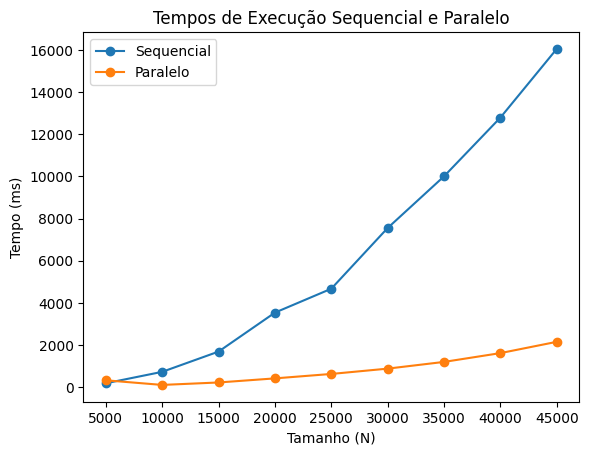

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
dados_array = []

with open("valores.txt", "r") as arquivo:
    linhas = arquivo.readlines()

for linha in linhas:
    valores = linha.strip().split(";")
    valores = [valor for valor in valores if valor]
    dados_array.append(valores)
def plot_data(data1, data2, indices):

    plt.plot(indices, data1, label='Sequencial', marker='o')
    plt.plot(indices, data2, label='Paralelo', marker='o')

    plt.xlabel('Tamanho (N)')
    plt.ylabel('Tempo (ms)')
    plt.title('Tempos de Execução Sequencial e Paralelo')
    plt.legend()

    plt.show()
N = []
sequencial = []
paralelo = []

for valor in dados_array:
    N.append(valor[0])
    sequencial.append(float(valor[1]))
    paralelo.append(float(valor[2]))

plot_data(sequencial, paralelo, N)

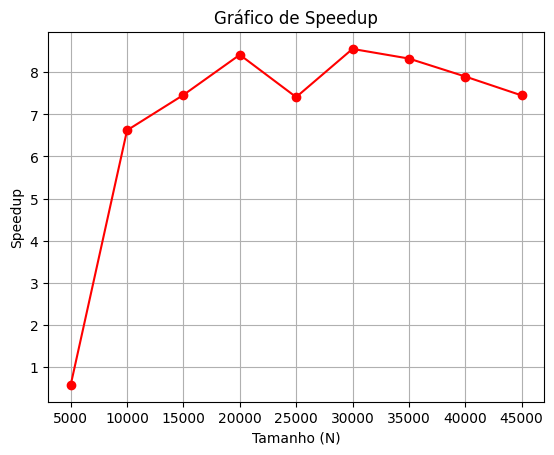

In [ ]:
resultado_divisao = []
for valor1, valor2 in zip(sequencial, paralelo):
    resultado = float(valor1) / float(valor2)
    resultado_divisao.append(float(resultado))

plt.plot(N, resultado_divisao, marker='o', color='red')

plt.xlabel('Tamanho (N)')
plt.ylabel('Speedup')
plt.title('Gráfico de Speedup')
plt.grid()

plt.show()